## Vision Transformer (ViT)

El **Vision Transformer (ViT)** es un modelo innovador para la clasificación de imágenes que transforma las imágenes en secuencias de parches más pequeños, comúnmente de $16 \times 16$ píxeles, como se describe en el paper de [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy)  "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Cada parche se considera como una "palabra" o "token" y se proyecta en un espacio de características. Mediante la incorporación de cifrados de posición y un token de clasificación, podemos aplicar un Transformer de manera convencional a esta secuencia, permitiendo su entrenamiento para tareas de clasificación de imágenes.

## Embeddings y Cifrado de Posición

### Embeddings
En el contexto de ViTs, las imágenes son primero divididas en pequeños bloques o patches (como si se cortaran en pequeños cuadrados). Estos patches se tratan como si fueran palabras en un modelo de lenguaje, y a cada uno se le asigna un embedding. Un embedding es simplemente una representación numérica del patch en un espacio de alta dimensión que captura características relevantes del mismo.

Por ejemplo, si divides una imagen de 224x224 píxeles en 16x16 bloques, tendrás 196 patches en total. Cada uno de esos patches se convierte en un vector de embedding, que luego se alimenta al modelo Transformer.

### Positional Embedding (Cifrado Posicional):

El **embedding posicional** agrega información sobre la ubicación de cada parche en la imagen original. En el paper de Alexey Dosovitskiy et al., se evaluaron varias formas de codificar la información espacial con embebidos posicionales. Se observó que, aunque el uso de embebidos mejora el rendimiento en comparación con no usarlos, no hay diferencias significativas entre los métodos probados. Se concluyó que, dado que el modelo opera a nivel de parches en lugar de píxeles, la forma específica de codificar la posición es menos relevante.

## Proceso de Creación de Embeddings

1. **División en Parches**: La imagen se divide en parches de $N \times N$ píxeles.
   
2. **Generación de Embeddings**: Cada parche se transforma en un embedding que captura su información relevante.

3. **Cifrado de Posición**: Se añade un vector de cifrado de posición a cada embedding. 

   Algunos ejemplos del cifrado:

   *  **Codificación Sinusoidal:** La fórmula sinusoidal para embebidos posicionales (tradicional en Transformers-NLP) genera los valores de los embebidos en función de senos y cosenos. Estos valores dependen directamente de la posición y siguen una periodicidad específica para capturar relaciones posicionales. Es determinista y no se ajusta durante el entrenamiento, ya que los valores están calculados y fijos para cada posición.
   Donde:
       - $pos$ es la posición en la secuencia.
       - $i$ es el índice de la dimensión.
       - $d_{model}$ es la dimensión del modelo.

   $$PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$

   $$PE(pos, 2i + 1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$

   * **Embebido Posicional Aprendido (a ser implementada por el alumno):** los embebidos posicionales se definen como un parámetro de la red neuronal (usando [nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)), lo que significa que los valores para el embebido  posicional se aprenden durante el proceso de entrenamiento. Se define embedding, matriz de tamaño (1, num_patches, embed_dim), donde num_patches es el número de parches (posiciones) en la secuencia de la imagen y  embed_dim es la dimensión de los embebidos. La inicialización torch.randn genera valores aleatorios para estos embebidos posicionales, y luego el modelo los optimiza durante el entrenamiento, ajustando los valores en función de los gradientes.

4. **Combinación de Embeddings y Cifrado de Posición**: Se suma cada embedding con su correspondiente cifrado de posición, generando un vector final que contiene tanto la información del contenido del parche como su posición en la imagen.

El resultado es una serie de vectores, cada uno representando un parche y su posición, que se alimentan a las capas del Transformer. Esto permite al modelo aprender no solo sobre las características individuales de cada parche, sino también sobre cómo estos se relacionan entre sí en el contexto de la imagen completa.

A continuación, trabajaremos con los **patch embeddings** y la **codificación posicional**, esenciales para que el modelo pueda interpretar las relaciones espaciales en las imágenes. 

## Tareas:

1. **Modificar los parametros:** Cambiar el tamaño de los parches, y la cantidad de dimensiones del embedding. Investigar y describir las ventajas y desventajas de tener más o menos parches/dimensiones.

2. **Implementar embedding posicional aprendido 1D:** Partiendo de ejemplo proporcionado (codificación sinusoidal en clase PositionalEncoding), implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. Graficar.

Dispositivo utilizado: cpu


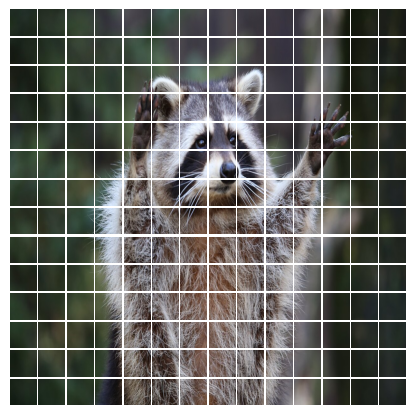

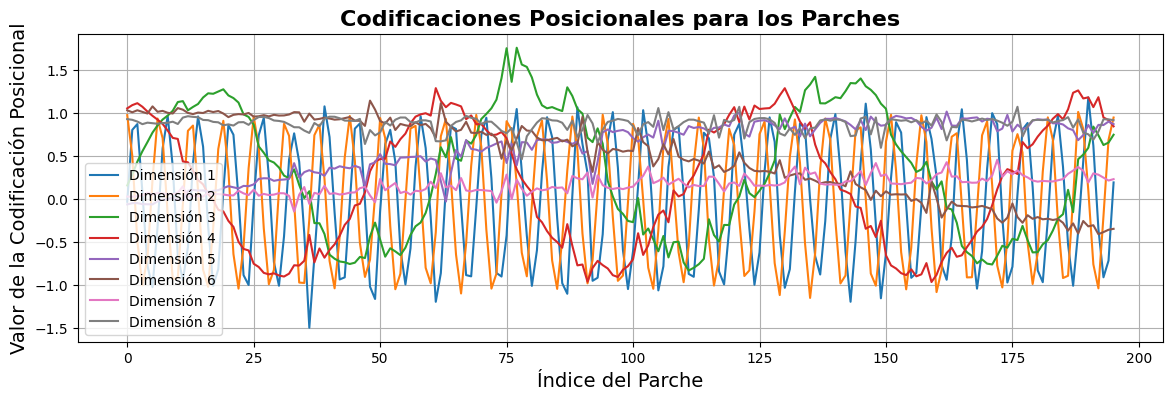

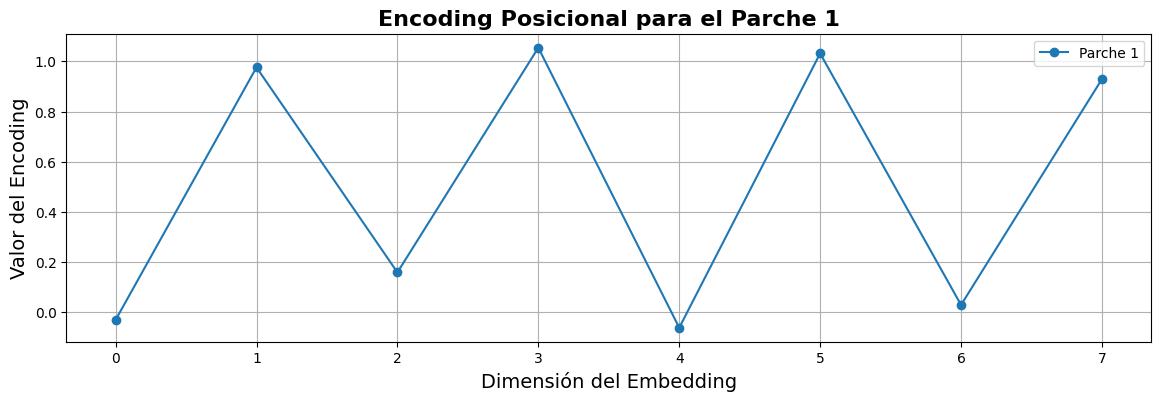

In [5]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import math

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, img_path: str, img_size: int, patch_size: int):
        self.device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
        print(f'Dispositivo utilizado: {self.device}')

        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches


class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pos_embedding', self.create_positional_encoding(num_patches, embed_dim))

    def create_positional_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pos_encoding = torch.zeros(num_patches, embed_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)  # Aplicar seno en dimensiones pares
        pos_encoding[:, 1::2] = torch.cos(position * div_term)  # Aplicar coseno en dimensiones impares
        return pos_encoding.unsqueeze(0)  # Añadir dimensión de batch

    def forward(self, x):
        return x + self.pos_embedding

class Visualization:
    @staticmethod  # No requiere self
    def visualize_patches(patches: Tensor):
        num_patches = patches.shape[1]
        num_cols = int(num_patches ** 0.5)
        num_rows = (num_patches + num_cols - 1) // num_cols
        _, axs = plt.subplots(num_rows, num_cols, figsize=(4, 4))
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                if idx < num_patches:
                    patch = patches[:, idx]
                    num_channels = patch.shape[0]
                    if num_channels == 1:
                        axs[i, j].imshow(patch.squeeze().detach().cpu().numpy(), cmap='gray')
                    elif num_channels == 3:
                        axs[i, j].imshow(patch.permute(1, 2, 0).detach().cpu().numpy())
                    axs[i, j].axis('off')
                else:
                    axs[i, j].axis('off')
        plt.tight_layout(pad=0.15)
        plt.show()

    @staticmethod  # No requiere self
    def visualize_positional_encoding(pos_embeddings: Tensor):
        plt.figure(figsize=(14, 4))
        plt.title('Codificaciones Posicionales para los Parches', fontsize=16, weight='bold')
        for i in range(pos_embeddings.shape[2]):
            plt.plot(pos_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dimensión {i + 1}')
        plt.xlabel('Índice del Parche', fontsize=14)
        plt.ylabel('Valor de la Codificación Posicional', fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

    @staticmethod
    def visualize_single_patch_encoding(pos_embeddings: Tensor, patch_idx: int):
        num_patches = pos_embeddings.shape[1]
        if patch_idx < 0 or patch_idx >= num_patches:
            raise ValueError(f"El índice del parche debe estar entre 0 y {num_patches - 1}, pero se recibió {patch_idx}.")
        patch_encoding = pos_embeddings[0, patch_idx, :].detach().cpu().numpy()
        plt.figure(figsize=(14, 4))
        plt.plot(patch_encoding, marker='o', label=f'Parche {patch_idx + 1}')
        plt.title(f'Encoding Posicional para el Parche {patch_idx + 1}', fontsize=16, weight='bold')
        plt.xlabel('Dimensión del Embedding', fontsize=14)
        plt.ylabel('Valor del Encoding', fontsize=14)
        plt.grid()
        plt.legend()
        plt.show()


# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional
num_patches = (img_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)

----
## Resolución

### 1. Modificación de parámetros

Dispositivo utilizado: cpu
Dispositivo utilizado: cpu
Dispositivo utilizado: cpu
Dispositivo utilizado: cpu
    patch_size  embed_dim  num_patches  token_size  processing_time
0            8          8        12544      100352           0.0036
1            8         16        12544      200704           0.0066
2            8         32        12544      401408           0.0064
3            8         64        12544      802816           0.0241
4           16          8         3136       25088           0.0026
5           16         16         3136       50176           0.0039
6           16         32         3136      100352           0.0046
7           16         64         3136      200704           0.0128
8           32          8          784        6272           0.0024
9           32         16          784       12544           0.0044
10          32         32          784       25088           0.0052
11          32         64          784       50176           0.0146
12      

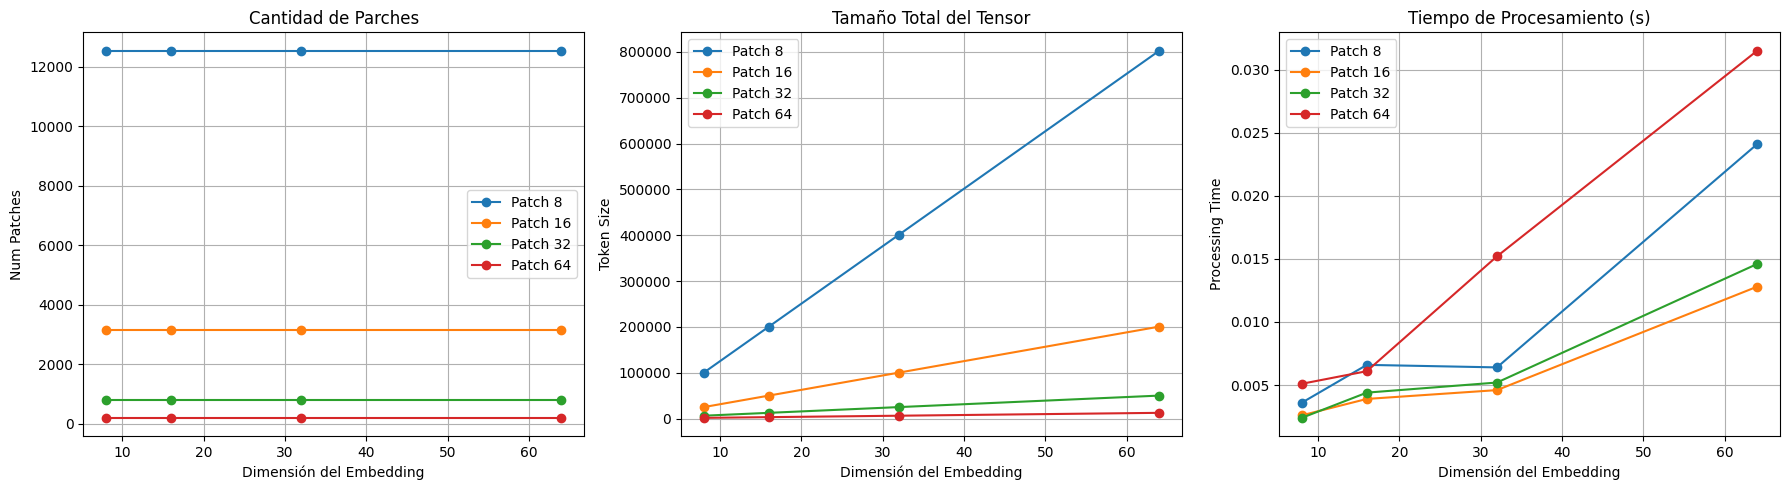

In [7]:
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt

def run_experiments(img_path, img_size, patch_sizes, embed_dims):
    device = 'cpu'
    results = []

    for patch_size in patch_sizes:
        # Preprocesamiento general para este patch_size
        config = ConfigPreprocess(img_path, img_size, patch_size)

        for embed_dim in embed_dims:
            # Calcular número de parches
            num_patches = (img_size // patch_size) ** 2

            # Instanciar modelos de embedding y codificación posicional
            patch_embed = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(device)
            pos_enc = PositionalEncoding(num_patches, embed_dim).to(device)

            # Medir tiempo
            start = time.time()
            embedded = patch_embed(config.test_img)
            encoded = pos_enc(embedded)
            end = time.time()

            results.append({
                'patch_size': patch_size,
                'embed_dim': embed_dim,
                'num_patches': num_patches,
                'token_size': encoded.numel(),
                'processing_time': round(end - start, 4)
            })

    return pd.DataFrame(results)

# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_sizes = [8, 16, 32, 64]
embed_dims = [8, 16, 32, 64]

# Ejecutar experimentos
df = run_experiments(img_path, img_size, patch_sizes, embed_dims)
print(df)

# Visualización
def plot_experiment_results(df):
    _, axs = plt.subplots(1, 3, figsize=(18, 5))

    metrics = ['num_patches', 'token_size', 'processing_time']
    titles = ['Cantidad de Parches', 'Tamaño Total del Tensor', 'Tiempo de Procesamiento (s)']

    for i, metric in enumerate(metrics):
        ax = axs[i]
        for patch_size in sorted(df['patch_size'].unique()):
            subset = df[df['patch_size'] == patch_size]
            ax.plot(subset['embed_dim'], subset[metric], marker='o', label=f'Patch {patch_size}')
        ax.set_title(titles[i])
        ax.set_xlabel('Dimensión del Embedding')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_experiment_results(df)

Los resultados muestran que reducir el tamaño del parche incrementa significativamente la cantidad de tokens, lo que mejora la resolución espacial y la capacidad del modelo para captar detalles finos, pero también eleva de forma drástica el costo computacional debido a la atención cuadrática (N²). Parches más grandes reducen la cantidad de tokens, haciendo el procesamiento mucho más eficiente, aunque sacrifican información espacial importante. 

Aumentar la dimensión del embedding permite representar más información por token, lo cual puede mejorar la capacidad expresiva del modelo, pero también aumenta el uso de memoria y el tiempo de ejecución. Tamaños de parche intermedios (como 16×16) ofrecen un buen balance entre rendimiento y costo.

---
### 2. Implementación del embedding posicional aprendido 1D

In [8]:
class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embedding

Dispositivo utilizado: cpu


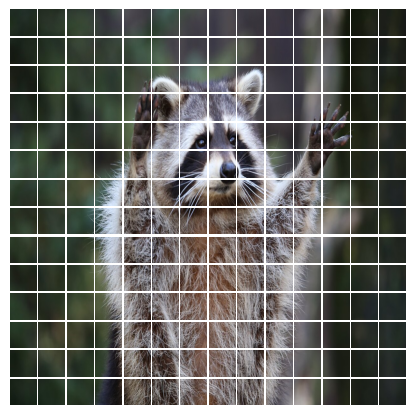

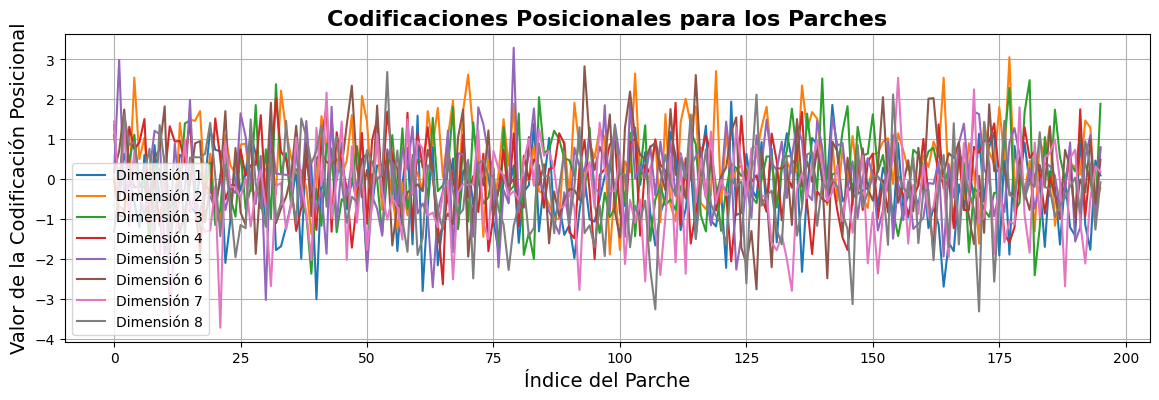

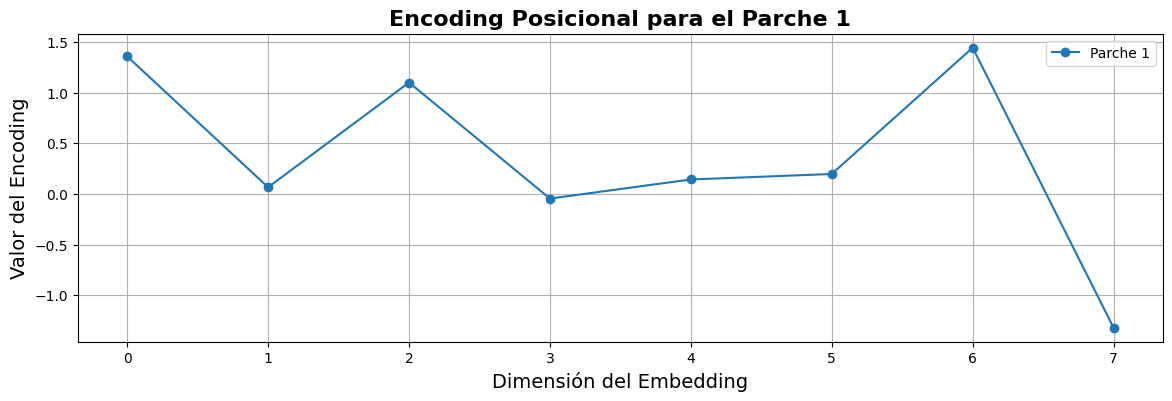

In [9]:
# Configuración principal
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0

# Preprocesamiento
config = ConfigPreprocess(img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional aprendida
num_patches = (img_size // patch_size) ** 2
learned_positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
learned_pos_embeddings = learned_positional_encoding(patches)

# Visualización
Visualization.visualize_positional_encoding(learned_pos_embeddings)
Visualization.visualize_single_patch_encoding(learned_pos_embeddings, patch_idx)

Se observa que los embeddings muestran patrones no periódicos a diferencia de la versión sinusoidal y cada dimensión del embedding desarrolló su propio patrón característico.
Durante el entrenamiento estos parámetros se ajustarán para capturar relaciones posicionales específicas de la tarea.